In [25]:
from flipside import Flipside
import numpy as np
import pandas as pd 
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [26]:
""" This repo GITIGNORES api_key.txt, use this convention to store your key safely"""

with open('api_key.txt', 'r') as file:
    # Read the first line
    api_key = file.readline().strip()  # .strip() removes newline characters


"""Initialize Flipside with your API Key / API Url"""
flipside = Flipside(api_key, "https://api-v2.flipsidecrypto.xyz")


In [27]:
sql = """WITH RECURSIVE date_series AS (
  SELECT
    '2024-02-01' :: DATE AS day
  UNION
  ALL
  SELECT
    day + INTERVAL '1 day'
  FROM
    date_series
  WHERE
    day < CURRENT_DATE
),
traders AS (
  SELECT
    ORIGIN_FROM_ADDRESS,
    SUM(AMOUNT_OUT_USD) AS Volume
  FROM
    ethereum.defi.ez_dex_swaps
  GROUP BY
    ORIGIN_FROM_ADDRESS
  HAVING
    SUM(AMOUNT_OUT_USD) > 10000000
    AND MIN(BLOCK_TIMESTAMP) >= '2024-02-01'
    AND MIN(BLOCK_TIMESTAMP) < '2024-03-01'
  ORDER BY
    SUM(AMOUNT_OUT_USD) DESC
  LIMIT
    500
),
symbols AS (
  SELECT
    DISTINCT SYMBOL,
    COALESCE(
      CONTRACT_ADDRESS,
      '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2'
    ) AS token_contract
  FROM
    ethereum.core.ez_balance_deltas
  WHERE
    USER_ADDRESS IN (
      SELECT DISTINCT ORIGIN_FROM_ADDRESS FROM traders
    )
    AND HAS_PRICE = TRUE
),
daily_balances AS (
  SELECT
    DATE_TRUNC('day', BLOCK_TIMESTAMP) AS day,
    SYMBOL,
    CURRENT_BAL AS daily_balance,
    COALESCE(
      CONTRACT_ADDRESS,
      '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2'
    ) AS token_contract,
    BLOCK_TIMESTAMP,
    USER_ADDRESS
  FROM
    ethereum.core.ez_balance_deltas
  WHERE
    USER_ADDRESS IN (
      SELECT DISTINCT ORIGIN_FROM_ADDRESS FROM traders
    )
    AND HAS_PRICE = TRUE
),
ranked_balances AS (
  SELECT
    day,
    SYMBOL,
    daily_balance,
    token_contract,
    USER_ADDRESS,
    ROW_NUMBER() OVER (
      PARTITION BY token_contract, day
      ORDER BY BLOCK_TIMESTAMP DESC
    ) AS rn
  FROM
    daily_balances
),
filtered_balances AS (
  SELECT
    day,
    SYMBOL,
    daily_balance,
    token_contract,
    USER_ADDRESS
  FROM
    ranked_balances
  WHERE
    rn = 1
),
filled_balances AS (
  SELECT
    ds.day,
    s.SYMBOL,
    COALESCE(fb.daily_balance, 0) AS filled_balance,
    fb.USER_ADDRESS,
    CASE
      WHEN s.SYMBOL = 'ETH' THEN LOWER('0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2')
      ELSE fb.token_contract
    END AS token_contract
  FROM
    date_series ds
    CROSS JOIN symbols s
    LEFT JOIN filtered_balances fb ON fb.day <= ds.day
    AND fb.SYMBOL = s.SYMBOL QUALIFY ROW_NUMBER() OVER (
      PARTITION BY ds.day, s.SYMBOL
      ORDER BY fb.day DESC
    ) = 1
),
latest_prices AS (
  SELECT
    DATE_TRUNC('day', hour) AS day,
    TOKEN_ADDRESS,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY PRICE) AS price
  FROM
    ethereum.price.ez_prices_hourly
  GROUP BY
    DATE_TRUNC('day', hour), TOKEN_ADDRESS
),
balances_with_prices AS (
  SELECT
    fb.day,
    fb.SYMBOL,
    fb.filled_balance,
    USER_ADDRESS,
    lp.PRICE AS daily_price,
    fb.filled_balance * lp.PRICE AS value_in_usd
  FROM
    filled_balances fb
    LEFT JOIN latest_prices lp ON lp.TOKEN_ADDRESS = fb.token_contract
    AND lp.day = fb.day
),
aggregated_by_day AS (
  SELECT
    day,
    daily_price,
    SYMBOL,
    USER_ADDRESS,
    SUM(filled_balance) AS total_filled_balance,
    SUM(value_in_usd) AS total_value_in_usd
  FROM
    balances_with_prices
  GROUP BY
    day, SYMBOL, USER_ADDRESS, daily_price
),
aggregated_added AS (
  SELECT
    a.day,
    a.SYMBOL,
    a.daily_price,
    a.total_filled_balance,
    a.USER_ADDRESS,
    a.total_value_in_usd,
    SUM(a.total_value_in_usd) OVER (PARTITION BY a.day, a.USER_ADDRESS) AS total_usd_in_treasury
  FROM
    aggregated_by_day a
  WHERE
    a.day <= CURRENT_DATE - 1
    AND a.daily_price > 0
  ORDER BY
    a.day DESC, a.SYMBOL
),
aggregated_added2 AS (
  SELECT
    *,
    total_value_in_usd / NULLIF(total_usd_in_treasury, 0) AS composition
  FROM
    aggregated_added
  ORDER BY
    day DESC, SYMBOL, USER_ADDRESS
),
daily_returns AS (
  SELECT
    day,
    SYMBOL,
    daily_price,
    composition,
    total_filled_balance,
    total_usd_in_treasury,
    USER_ADDRESS,
    LAG(daily_price) OVER (PARTITION BY SYMBOL ORDER BY day) AS prev_day_price,
    (daily_price - LAG(daily_price) OVER (PARTITION BY SYMBOL ORDER BY day)) / LAG(daily_price) OVER (PARTITION BY SYMBOL ORDER BY day) AS daily_return
  FROM
    aggregated_added2
),
weighted_daily_returns AS (
  SELECT
    day,
    USER_ADDRESS,
    daily_return,
    SUM(daily_return * composition) AS weighted_daily_return
  FROM
    daily_returns
  GROUP BY
    day, USER_ADDRESS, daily_return
),
cumulative_returns AS (
  SELECT
    day,
    daily_return,
    weighted_daily_return,
    USER_ADDRESS,
    (1 + weighted_daily_return) AS daily_factor,
    EXP(SUM(LN(1 + weighted_daily_return)) OVER (PARTITION BY USER_ADDRESS ORDER BY day ASC)) - 1 AS cumulative_return
  FROM
    weighted_daily_returns
),
base_return AS (
  SELECT
    day,
    USER_ADDRESS,
    daily_return,
    cumulative_return AS base_cumulative_return
  FROM
    cumulative_returns
  WHERE
    cumulative_return IS NOT NULL
),
normalized_returns AS (
  SELECT
    day,
    USER_ADDRESS,
    daily_return,
    base_cumulative_return,
    100 + (100 * (base_cumulative_return - FIRST_VALUE(base_cumulative_return) OVER (PARTITION BY USER_ADDRESS ORDER BY day ASC))) AS portfolio_return
  FROM
    base_return
),
return_stats AS (
  SELECT
    day,
    USER_ADDRESS,
    base_cumulative_return,
    portfolio_return,
    AVG(portfolio_return) OVER (PARTITION BY USER_ADDRESS ORDER BY day ASC) AS avg_daily_return,
    STDDEV(portfolio_return) OVER (PARTITION BY USER_ADDRESS ORDER BY day ASC) AS stddev_return
  FROM
    normalized_returns
),
sharpe_ratio AS (
  SELECT
    day,
    USER_ADDRESS,
    base_cumulative_return,
    portfolio_return,
    NULLIF((portfolio_return - 0.0430 / 365) / NULLIF(STDDEV(portfolio_return) OVER (PARTITION BY USER_ADDRESS ORDER BY day ASC), 0), 0) AS daily_sharpe_ratio
  FROM
    return_stats
),
trade_counts AS (
  SELECT
    DATE_TRUNC('day', BLOCK_TIMESTAMP) AS day,
    ORIGIN_FROM_ADDRESS AS USER_ADDRESS,
    COUNT(DISTINCT tx_hash) AS number_of_trades
  FROM
    ethereum.defi.ez_dex_swaps
  GROUP BY
    day, ORIGIN_FROM_ADDRESS
),

tokens_traded AS (
  SELECT
    DATE_TRUNC('day', BLOCK_TIMESTAMP) AS day,
    ORIGIN_FROM_ADDRESS AS USER_ADDRESS,
    COUNT(DISTINCT SYMBOL_OUT) AS unique_tokens_traded
  FROM
    ethereum.defi.ez_dex_swaps
  GROUP BY
    day, ORIGIN_FROM_ADDRESS
),

final_normalized_returns AS (
  SELECT
    sr.day,
    sr.USER_ADDRESS,
    sr.base_cumulative_return,
    sr.portfolio_return,
    sr.daily_sharpe_ratio,
    CASE
      WHEN AVG(sr.portfolio_return) > 120 AND sr.daily_sharpe_ratio > 1.5 THEN 'Good Trader'
      WHEN AVG(sr.portfolio_return) BETWEEN 100 AND 120 THEN 'Average Trader'
      WHEN AVG(sr.portfolio_return) < 100 THEN 'Bad Trader'
    END AS trader_class
  FROM
    sharpe_ratio sr
  WHERE
    sr.daily_sharpe_ratio IS NOT NULL
  GROUP BY
    sr.day, sr.USER_ADDRESS, sr.base_cumulative_return, sr.portfolio_return, sr.daily_sharpe_ratio
)

SELECT
  fnr.day,
  fnr.USER_ADDRESS,
  fnr.base_cumulative_return,
  fnr.portfolio_return,
  fnr.daily_sharpe_ratio,
  fnr.trader_class,
  tc.number_of_trades,
  tt.unique_tokens_traded
FROM
  final_normalized_returns fnr
  LEFT JOIN trade_counts tc ON tc.day = fnr.day AND tc.USER_ADDRESS = fnr.USER_ADDRESS
  LEFT JOIN tokens_traded tt ON tt.day = fnr.day AND tt.USER_ADDRESS = fnr.USER_ADDRESS;
"""
"""Run the query against Flipside's query engine and await the results"""
query_result_set = flipside.query(sql)
#print(query_result_set)

KeyboardInterrupt: 

In [4]:
"""This function will be added to Flipside package after testing, just copy/paste as needed for now"""
def auto_paginate_result(query_result_set, page_size=10000):
    """
    This function auto-paginates a query result to get all the data. It assumes 10,000 rows per page.
    In case of an error, reduce the page size. Uses numpy.
    """
    num_rows = query_result_set.page.totalRows
    page_count = np.ceil(num_rows / page_size).astype(int)
    all_rows = []
    current_page = 1
    while current_page <= page_count:
        results = flipside.get_query_results(
            query_result_set.query_id,
            page_number=current_page,
            page_size=page_size
        )
        if results.records:
            all_rows.extend(results.records)  # Use extend() to add list elements
        current_page += 1  # Increment the current page number
    return all_rows  # Return all_rows in JSON format


In [24]:
""" Get your data as a pandas data frame"""

trader_classifier = auto_paginate_result(query_result_set)
df = pd.DataFrame(trader_classifier)

# Set the display option to show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)  # Adjusts the display width for better visibility

#Display Dataframe
print(df.head())

KeyboardInterrupt: 

In [9]:
#Drop the "__row_index" column
df_t = df.drop(columns = ['__row_index'])

#Remove later
print(df_t.head())

                        day                                user_address  base_cumulative_return  portfolio_return  daily_sharpe_ratio trader_class  number_of_trades  unique_tokens_traded
0  2024-09-28T00:00:00.000Z  0x448166a91e7bc50d0ac720c2fbed29e0963f5af8               -0.637452         36.009586            2.532402   Bad Trader             745.0                  51.0
1  2024-04-22T00:00:00.000Z  0xd0640fcb1ef5ac385b57701c5ef7030331c8d80b                8.014126        894.536913            3.808686  Good Trader               9.0                   5.0
2  2024-05-06T00:00:00.000Z  0x7ccdb15ff25dddb23dd0efc98844e07683cd8ba6               -0.025023         95.767726           15.705438   Bad Trader             121.0                   3.0
3  2024-09-20T00:00:00.000Z  0x3e55457808fb552a7f1989d68c9daf5d3a51c027               -0.362267         67.855890            3.889502   Bad Trader               NaN                   NaN
4  2024-02-13T00:00:00.000Z  0x580e4ce9d324426e8e5e2a33298a1d2fd7

In [11]:
# Convert 'day' column to datetime format and remove time component 
df_t['day']=pd.to_datetime(df_t['day']).dt.date

#Remove later
print(df_t.head())

          day                                user_address  base_cumulative_return  portfolio_return  daily_sharpe_ratio trader_class  number_of_trades  unique_tokens_traded
0  2024-09-28  0x448166a91e7bc50d0ac720c2fbed29e0963f5af8               -0.637452         36.009586            2.532402   Bad Trader             745.0                  51.0
1  2024-04-22  0xd0640fcb1ef5ac385b57701c5ef7030331c8d80b                8.014126        894.536913            3.808686  Good Trader               9.0                   5.0
2  2024-05-06  0x7ccdb15ff25dddb23dd0efc98844e07683cd8ba6               -0.025023         95.767726           15.705438   Bad Trader             121.0                   3.0
3  2024-09-20  0x3e55457808fb552a7f1989d68c9daf5d3a51c027               -0.362267         67.855890            3.889502   Bad Trader               NaN                   NaN
4  2024-02-13  0x580e4ce9d324426e8e5e2a33298a1d2fd73273a7                0.314123        133.011113            7.995082  Good Trader   

In [13]:
# Define a function to detect outliers based on IQR
def find_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

#Find outliers for 'portfolio_return'
outliers = find_outliers_iqr(df_t, 'portfolio_return')
print(outliers)


              day                                user_address  base_cumulative_return  portfolio_return  daily_sharpe_ratio trader_class  number_of_trades  unique_tokens_traded
1      2024-04-22  0xd0640fcb1ef5ac385b57701c5ef7030331c8d80b            8.014126e+00      8.945369e+02            3.808686  Good Trader               9.0                   5.0
7      2024-08-10  0xd0640fcb1ef5ac385b57701c5ef7030331c8d80b            2.651073e+01      2.744197e+03            8.062434  Good Trader               1.0                   1.0
9      2024-06-29  0xe99bc90d3cb86cf095d75a020c10fbf9d4aa9a4d            1.145338e+08      1.145338e+10            1.622926  Good Trader               4.0                   3.0
10     2024-09-13  0x38ab25a76260b3afd48b83d21fba36ea72bf878e            4.343556e+05      4.343563e+07            0.453322         None              41.0                   2.0
11     2024-06-12  0x6f5884a6ba14297eab47aa52c4e739f0a11ff7c1            2.744965e+07      2.744965e+09            

In [19]:
# Remove outliers from 'portfolio_return' column based on IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply the function to remove outliers from the 'portfolio_return' column
df_clean = remove_outliers_iqr(df_t, 'portfolio_return')

# Verify the result
print(df_clean)


              day                                user_address  base_cumulative_return  portfolio_return  daily_sharpe_ratio    trader_class  number_of_trades  unique_tokens_traded
0      2024-09-28  0x448166a91e7bc50d0ac720c2fbed29e0963f5af8               -0.637452         36.009586            2.532402      Bad Trader             745.0                  51.0
2      2024-05-06  0x7ccdb15ff25dddb23dd0efc98844e07683cd8ba6               -0.025023         95.767726           15.705438      Bad Trader             121.0                   3.0
3      2024-09-20  0x3e55457808fb552a7f1989d68c9daf5d3a51c027               -0.362267         67.855890            3.889502      Bad Trader               NaN                   NaN
4      2024-02-13  0x580e4ce9d324426e8e5e2a33298a1d2fd73273a7                0.314123        133.011113            7.995082     Good Trader               4.0                   5.0
5      2024-07-11  0xb8ca7f877391032d9da4c995d64cdab3ecd03efd               -0.271913         72.000

In [23]:
# Check for NaN values in the entire DataFrame
print(df_clean.isna().sum())

day                           0
user_address                  0
base_cumulative_return        0
portfolio_return              0
daily_sharpe_ratio            0
trader_class                  8
number_of_trades          10619
unique_tokens_traded      10619
dtype: int64


In [22]:

print(df_clean['trader_class'].isna().sum())

8


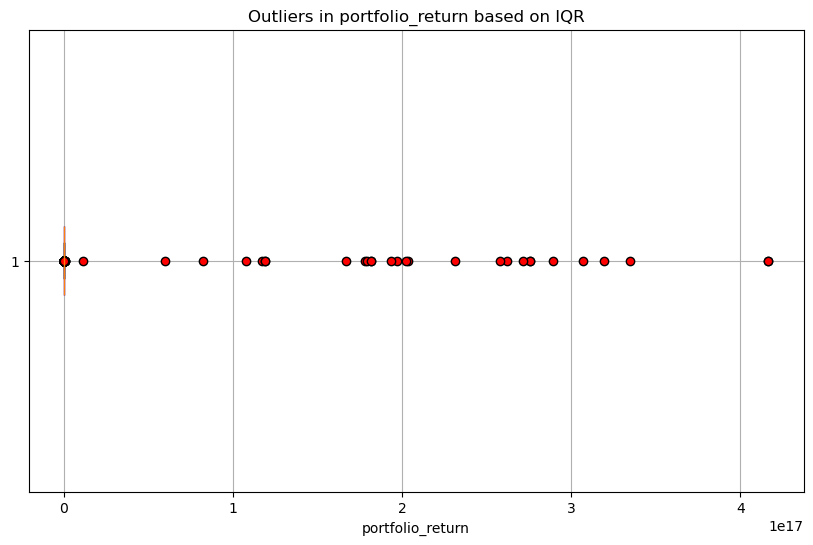

In [18]:
# Assuming trader_classifier_df is your DataFrame
def plot_outliers(df, column):
    plt.figure(figsize=(10, 6))
    plt.boxplot(df[column], vert=False, patch_artist=True, 
                boxprops=dict(facecolor='lightblue', color='blue'),
                flierprops=dict(marker='o', markerfacecolor='red', markersize=6))
    plt.title(f'Outliers in {column} based on IQR')
    plt.xlabel(column)
    plt.grid(True)
    plt.show()

# Example: Visualize outliers for 'portfolio_return'
plot_outliers(outliers, 'portfolio_return')